# ML to find radial velocities using GALAXIA sim with Nearest Neighbors

In [1]:
%matplotlib inline


import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec
from scipy.stats import norm

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/processed_stars_reshuffled_with_pos_vel.npy')

In [3]:
data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
             'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
             'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
#could train on radial_velocity_error

In [4]:
data_train = pd.DataFrame(data[:32000], columns=data_cols)
data_val = pd.DataFrame(data[32001:40000], columns=data_cols)
data_test = pd.DataFrame(data[40000:50000], columns=data_cols)

In [5]:
data_train.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,z,vx,vy,vz,r,phi,theta,vr,vphi,vtheta
0,5.061412e+17,131.353790,-3.668921,28.938131,58.147300,0.558357,0.025379,-2.61794,0.017121,-0.673081,...,-0.099606,59.186430,214.909786,-0.599243,9.278926,171.686082,90.615062,-27.481188,-221.209388,0.894295
1,4.793522e+17,146.070404,13.149321,74.581562,64.246163,1.284570,0.069426,9.32732,0.038823,-13.126400,...,0.192094,-22.250179,189.906749,6.232524,8.641484,177.192710,88.726251,31.655268,-188.589101,-5.530217
2,5.911549e+18,332.078064,-17.855680,269.959228,-61.602704,0.827003,0.066856,3.33253,0.037386,-6.251980,...,-0.355761,-7.266869,220.743054,-24.071507,7.012840,-175.586689,92.907859,-8.507313,-220.647719,24.534673
3,4.596623e+18,55.180511,24.729351,268.481942,29.790023,0.770408,0.034757,-3.17662,0.020937,-20.357300,...,0.558001,108.587009,160.244402,-19.909387,7.411502,172.474670,85.682199,-87.918403,-173.085269,13.327967
4,4.303083e+18,48.748230,-5.606678,295.265656,11.353417,0.478881,0.022046,-2.53293,0.008481,-5.662840,...,-0.189015,87.723856,233.675764,-2.739426,6.813941,166.738898,91.589557,-31.693813,-247.567647,3.619987


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [7]:
SS = StandardScaler()
data_train_scaled = SS.fit_transform(data_train)
data_val_scaled = SS.transform(data_val)
data_test_scaled = SS.transform(data_test)

In [8]:
data_train_scaled = pd.DataFrame(data_train_scaled, columns=data_cols)
data_val_scaled = pd.DataFrame(data_val_scaled, columns=data_cols)
data_test_scaled = pd.DataFrame(data_test_scaled, columns=data_cols)

In [9]:
#trying to add some weights to training data
#might weight the mean, but no weights on confidence model? (something to think about)
vr_real_train = (data_train_scaled['radial_velocity']).values
print(vr_real_train.shape)
vr_real_val = (data_val_scaled['radial_velocity']).values
print(vr_real_val.shape)

(32000,)
(7999,)


In [10]:
counts_train, bins_train = np.histogram(vr_real_train,bins=np.linspace(-700,700,51))
bin_centers_train = (bins_train[1:]+bins_train[:-1])/2
interp_func_train  = interp1d(bin_centers_train,(counts_train).astype('float'))
inv_weights_train = interp_func_train(vr_real_train)
weights_train = 1/inv_weights_train
weights_train = np.log(weights_train)
weights_train = weights_train - np.min(weights_train)+1
print(weights_train.shape)

(32000,)


In [11]:
counts_val, bins_val = np.histogram(vr_real_val,bins=np.linspace(-700,700,51))
bin_centers_val = (bins_val[1:]+bins_val[:-1])/2
interp_func_val  = interp1d(bin_centers_val,(counts_val).astype('float'))
inv_weights_val = interp_func_val(vr_real_val)
weights_val = 1/inv_weights_val
weights_val = np.log(weights_val)
weights_val = weights_val - np.min(weights_val)+1
#print(weights_val.shape)
#weights = np.concatenate((weights_train,weights_val))
#print(np.shape(weights))

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [13]:
from keras import backend as K
from keras import callbacks as callbacks
global index 

In [14]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6
    LOC = y_pred[:, 0]
    X = y_true
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean((ARG - PREFACT))


In [15]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
    print(y_true.shape)
    print(y_pred.shape)
    LOC = y_pred[:, 0]
    X = y_true
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT))


# Two network technique to calculate the error

In [16]:
from sklearn.neighbors import NearestNeighbors
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout, Activation, Add
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [17]:
class DataLoader(Sequence):
    
    def __init__(self, 
                 StarDF,  # Dataframe of the stars
                 DistanceVariables,  # column names for the combined distance
                 Features,  # Columns to output for machine learning
                 ToLearn,  # Column to learn
                 NNeighbors,
                 Weights,
                 batch_size=64, shuffle=True):
        'Initialization'
        self.df = StarDF
        self.num_neighbors = NNeighbors
        self.KNN = NearestNeighbors(n_neighbors=NNeighbors,
                                    n_jobs=-1
                                   )
        self.KNN.fit(self.df[DistanceVariables])
        dists, inds = self.KNN.kneighbors(self.df[DistanceVariables])
        self.knn_inds = inds
        self.features = Features
        self.weights = Weights
        self.tolearn = ToLearn
        
        self.indexes = np.arange(len(StarDF))
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
            'Denotes the number of batches per epoch'
            return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        max_ind = np.min([(index+1)*self.batch_size, len(self.df)])
        indexes = self.indexes[index*self.batch_size:max_ind]
        # Generate data
        X, y, weights = self.__data_generation(indexes)
        return X, y, weights

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, n_features*KNN)
        # Initialization
        Y = self.df[self.tolearn].values[list_IDs_temp]
        data = self.df[self.features].values
        X = data[self.knn_inds[list_IDs_temp]].reshape(len(list_IDs_temp), len(self.features) * self.num_neighbors)
        weights = self.weights[list_IDs_temp]
        
        return X, Y, weights

In [18]:
class DataLoader1(Sequence):
    
    def __init__(self, 
                 StarDF,  # Dataframe of the stars
                 DistanceVariables,  # column names for the combined distance
                 Features,  # Columns to output for machine learning
                 ToLearn,  # Column to learn
                 NNeighbors,
                 batch_size=64, shuffle=True):
        'Initialization'
        self.df = StarDF
        self.num_neighbors = NNeighbors
        self.KNN = NearestNeighbors(n_neighbors=NNeighbors,
                                    n_jobs=-1
                                   )
        self.KNN.fit(self.df[DistanceVariables])
        dists, inds = self.KNN.kneighbors(self.df[DistanceVariables])
        self.knn_inds = inds
        self.features = Features
        self.tolearn = ToLearn
        
        self.indexes = np.arange(len(StarDF))
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
            'Denotes the number of batches per epoch'
            return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        max_ind = np.min([(index+1)*self.batch_size, len(self.df)])
        indexes = self.indexes[index*self.batch_size:max_ind]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, n_features*KNN)
        # Initialization
        Y = self.df[self.tolearn].values[list_IDs_temp]
        data = self.df[self.features].values
        X = data[self.knn_inds[list_IDs_temp]].reshape(len(list_IDs_temp), len(self.features) * self.num_neighbors)

        
        return X, Y

In [19]:
TrainLoader = DataLoader(StarDF=data_train_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_train,
                      batch_size=10000
                     )
ValLoader = DataLoader(StarDF=data_val_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_val,
                      batch_size=10000
                     )
TestLoader = DataLoader1(StarDF=data_test_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      batch_size=10000
                     )

In [20]:
x, y ,weights = TrainLoader[0]
print(x.shape)
print(y.shape)
print(weights.shape)

(10000, 50)
(10000,)
(10000,)


In [21]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
input_shape=(TrainLoader[0][0].shape[-1],)
commonInput = Input(input_shape)
MeanEst = Sequential(name="MeanModel")
MeanEst.add(Dense(30, activation='relu',input_shape=(TrainLoader[0][0].shape[-1],)))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(30, activation='relu'))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(10, activation='relu'))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(10, activation='relu'))
MeanEst.add(Dense(1, activation='linear'))

ConfEst = Sequential(name="ConfModel")
ConfEst.add(Dense(30, activation='relu',input_shape=(TrainLoader[0][0].shape[-1],)))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='relu'))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='relu'))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='relu'))
ConfEst.add(Dense(1, activation='relu'))

out1 = MeanEst(commonInput)    
out2 = ConfEst(commonInput)    
mergedOut = Concatenate(axis=-1)([out1,out2])
CombinedModel = Model(commonInput, mergedOut)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [22]:
#CombinedModel.save_weights('modelsIterate/TrainingBoth_0000.hdf5')

In [23]:
CombinedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
MeanModel (Sequential)          (None, 1)            2891        input_1[0][0]                    
__________________________________________________________________________________________________
ConfModel (Sequential)          (None, 1)            4351        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           MeanModel[1][0]                  
                                                                 ConfModel[1][0]            

## First training iteration

In [24]:
CheckPoint = ModelCheckpoint('models_GALAXIA/TrainingMean_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger = CSVLogger(filename='logs/training_mean.log', separator=',', append=False)

mycallbacks = [CheckPoint, ES, RLR, CSV_logger]
#mycallbacks = [ES, RLR]

In [25]:
print(TrainLoader[0][0].shape)

(10000, 50)


In [26]:
ConfEst.trainable = False
MeanEst.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks
                 )

(None, None)
(None, 2)
Epoch 1/1000
4/4 [==============================] - 6s 1s/step - loss: 1.4990 - val_loss: 1.4608
Epoch 2/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4691 - val_loss: 1.4432
Epoch 3/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4406 - val_loss: 1.4371
Epoch 4/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4346 - val_loss: 1.4346
Epoch 5/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4294 - val_loss: 1.4329
Epoch 6/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4267 - val_loss: 1.4318
Epoch 7/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4276 - val_loss: 1.4311
Epoch 8/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4215 - val_loss: 1.4306
Epoch 9/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4297 - val_loss: 1.4304
Epoch 10/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4268 - val_loss: 1.4302
Epoch 

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

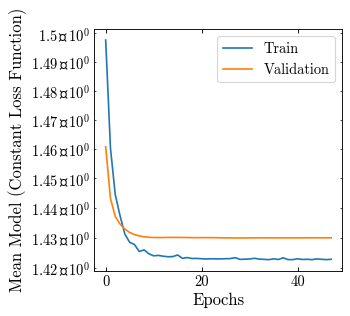

In [27]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [28]:
CheckPoint2 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger2 = CSVLogger(filename='logs/training_errorbars.log', separator=',', append=False)

mycallbacks2 = [CheckPoint2, ES2, RLR2, CSV_logger2]
#mycallbacks2 = [ES2, RLR2]

In [29]:
ConfEst.trainable = True
MeanEst.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks2
                 )

Epoch 1/1000
4/4 [==============================] - 11s 3s/step - loss: 363933792665.6000 - val_loss: 206029963264.0000
Epoch 2/1000
4/4 [==============================] - 10s 3s/step - loss: 208145817395.2000 - val_loss: 66758832128.0000
Epoch 3/1000
4/4 [==============================] - 10s 3s/step - loss: 106546445619.2000 - val_loss: 24782981120.0000
Epoch 4/1000
4/4 [==============================] - 11s 3s/step - loss: 49896875622.4000 - val_loss: 6007126528.0000
Epoch 5/1000
4/4 [==============================] - 10s 3s/step - loss: 25042266905.6000 - val_loss: 1438958464.0000
Epoch 6/1000
4/4 [==============================] - 11s 3s/step - loss: 14196288947.2000 - val_loss: 312801280.0000
Epoch 7/1000
4/4 [==============================] - 10s 3s/step - loss: 8728651347.2000 - val_loss: 187677728.0000
Epoch 8/1000
4/4 [==============================] - 10s 3s/step - loss: 6584240083.2000 - val_loss: 125119616.0000
Epoch 9/1000
4/4 [==============================] - 11s 3s/ste

KeyboardInterrupt: 

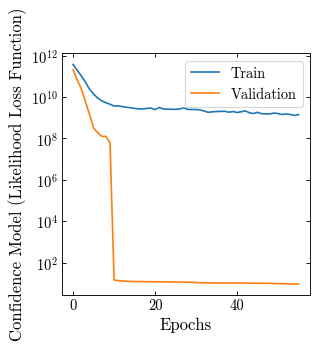

In [30]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Second Training Iteration

In [31]:
CheckPoint4 = ModelCheckpoint('models_GALAXIA/TrainingMean2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger4 = CSVLogger(filename='logs/training_mean2.log', separator=',', append=False)

mycallbacks4 = [CheckPoint4, ES4, RLR4, CSV_logger4]
#mycallbacks4 = [ES4, RLR4]

In [35]:
ConfEst.trainable = False
MeanEst.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks4
                 )

(None, None)
(None, 2)
Epoch 1/1000
4/4 [==============================] - 6s 1s/step - loss: 1.4206 - val_loss: 1.4299
Epoch 2/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4224 - val_loss: 1.4300
Epoch 3/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4264 - val_loss: 1.4300
Epoch 4/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4184 - val_loss: 1.4300
Epoch 5/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4237 - val_loss: 1.4300
Epoch 6/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4201 - val_loss: 1.4301
Epoch 7/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4162 - val_loss: 1.4301
Epoch 8/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4233 - val_loss: 1.4300
Epoch 9/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4209 - val_loss: 1.4300
Epoch 10/1000
4/4 [==============================] - 5s 1s/step - loss: 1.4249 - val_loss: 1.4300
Epoch 

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

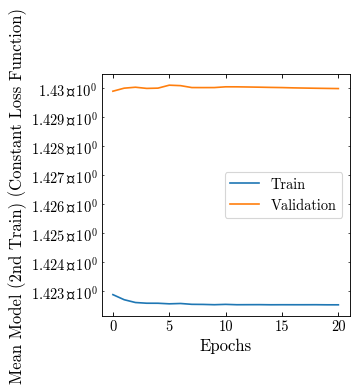

In [36]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (2nd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [39]:
CheckPoint5 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger5 = CSVLogger(filename='logs/training_errorbars2.log', separator=',', append=False)

mycallbacks5 = [CheckPoint5, ES5, RLR5, CSV_logger5]
#mycallbacks5 = [ES5, RLR5]

In [40]:
ConfEst.trainable = True
MeanEst.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks5
                 )

Epoch 1/1000
4/4 [==============================] - 11s 3s/step - loss: 465080777.5768 - val_loss: 5.3719
Epoch 2/1000
4/4 [==============================] - 10s 3s/step - loss: 156678069.8000 - val_loss: 3.9969
Epoch 3/1000
4/4 [==============================] - 11s 3s/step - loss: 39680435.9703 - val_loss: 3.2744
Epoch 4/1000
4/4 [==============================] - 11s 3s/step - loss: 12930412.7219 - val_loss: 2.8951
Epoch 5/1000
4/4 [==============================] - 10s 3s/step - loss: 3.3552 - val_loss: 2.6688
Epoch 6/1000
4/4 [==============================] - 10s 3s/step - loss: 2.9986 - val_loss: 2.5223
Epoch 7/1000
4/4 [==============================] - 11s 3s/step - loss: 2.8145 - val_loss: 2.4206
Epoch 8/1000
4/4 [==============================] - 11s 3s/step - loss: 2.6920 - val_loss: 2.3453
Epoch 9/1000
4/4 [==============================] - 11s 3s/step - loss: 2.5748 - val_loss: 2.2861
Epoch 10/1000
4/4 [==============================] - 10s 3s/step - loss: 2.5314 - val_lo

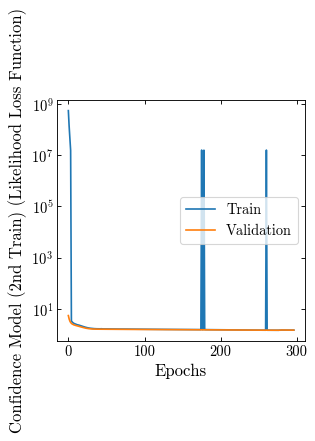

In [41]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (2nd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Third Training Iteration

In [ ]:
CheckPoint6 = ModelCheckpoint('models/TrainingMean3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger6 = CSVLogger(filename='logs/training_mean3.log', separator=',', append=False)

mycallbacks6 = [CheckPoint6, ES4, RLR4, CSV_logger6]
#mycallbacks4 = [ES4, RLR4]

In [ ]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks6
                 )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (3rd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
CheckPoint7 = ModelCheckpoint('models/TrainingErrorBars3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger7 = CSVLogger(filename='logs/training_errorbars3.log', separator=',', append=False)

mycallbacks7 = [CheckPoint7, ES5, RLR5, CSV_logger7]
#mycallbacks5 = [ES5, RLR5]

In [ ]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks7,
                 )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (3rd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Train Both

In [42]:
CheckPoint3 = ModelCheckpoint('models_GALAXIA/TrainingBoth_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES3 = EarlyStopping(patience=20, verbose=True, restore_best_weights=True)
RLR3 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger3 = CSVLogger(filename='logs/training_both.log', separator=',', append=False)

mycallbacks3 = [CheckPoint3, ES3, RLR3, CSV_logger3]
#mycallbacks3 = [ES3, RLR3]

In [44]:
ConfEst.trainable = True
MeanEst.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks3
                 )

Epoch 1/1000
4/4 [==============================] - 11s 3s/step - loss: 1.4385 - val_loss: 1.4348
Epoch 2/1000
4/4 [==============================] - 10s 3s/step - loss: 13112221.5078 - val_loss: 1.4335
Epoch 3/1000
4/4 [==============================] - 11s 3s/step - loss: 1.4286 - val_loss: 1.4334
Epoch 4/1000
4/4 [==============================] - 10s 3s/step - loss: 1.4274 - val_loss: 1.4325
Epoch 5/1000
4/4 [==============================] - 11s 3s/step - loss: 1.4280 - val_loss: 1.4320
Epoch 6/1000
4/4 [==============================] - 10s 3s/step - loss: 13101825.4533 - val_loss: 1.4319
Epoch 7/1000
4/4 [==============================] - 10s 3s/step - loss: 1.4296 - val_loss: 1.4317
Epoch 8/1000
4/4 [==============================] - 10s 3s/step - loss: 1.4251 - val_loss: 1.4319
Epoch 9/1000
4/4 [==============================] - 10s 3s/step - loss: 1.4325 - val_loss: 1.4323
Epoch 10/1000
4/4 [==============================] - 10s 3s/step - loss: 1.4222 - val_loss: 1.4320
Epoch

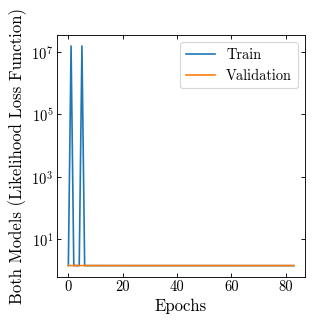

In [45]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Both Models (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.savefig('Loss_Plot_Iterate.png')
plt.show()

In [ ]:
 def plot_validation(i,type1):   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d( test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-10)

    plt.subplot(gs0[4])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_val[:,0]),np.max(y_val[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_val[:,2], test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],y_val[:,0]),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds[:,0],y_val[:,0])
    plt.hist2d(test_preds[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_val[:,0], bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Validation set, Train '+type1+', Epoch '+str(i)+', 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.savefig('plots'+type1+'/'+'train'+type1+'_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

#### Plotting First Training

In [ ]:
traininmean = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean_')]
traininmean = sorted(traininmean)[1::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean1');

In [ ]:
traininerror = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars_')]
traininerror = sorted(traininerror)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error1');

#### Plotting Second Training

In [ ]:
traininmean2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean2')]
traininmean2 = sorted(traininmean2)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean2):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean2');

In [ ]:
traininerror2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars2')]
traininerror2 = sorted(traininerror2)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror2):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error2');

#### Plotting Third Training

In [ ]:
traininmean3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean3')]
traininmean3 = sorted(traininmean3)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean3):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean3');

In [ ]:
traininerror3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars3')]
traininerror3 = sorted(traininerror3)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror3):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error3');

#### Plot results of training both

In [ ]:
traininboth = [file for file in os.listdir('models/')
               if file.startswith('TrainingBoth')]
traininboth = sorted(traininboth)[1::10]


In [ ]:
%%capture
for i_both, mfile_both in enumerate(traininboth):
    CombinedModel.load_weights('models/' + mfile_both)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_both*10,'Both');

In [47]:

y_low = -1
y_high = 1

### Evaluate the Test Set

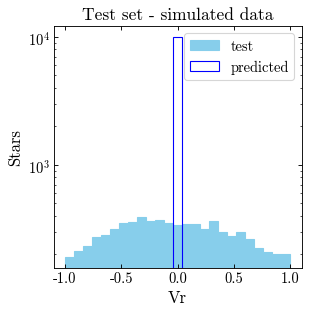

In [48]:
#CombinedModel.load_weights('train_30nodes_1it_500k/models/' + 'TrainingBoth_0131.hdf5')
test_preds_2 = CombinedModel.predict_generator(TestLoader)

plt.figure()
plt.hist((data_test_scaled['radial_velocity']).values, bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
plt.hist(test_preds_2[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right")
plt.show()

In [ ]:
print(y_high)

## Going to use Monte Carlo simulations to predict errorbars. 

In [ ]:
mc_vr_pred_list = []
bin_values_list = []
min_array = []
max_array = []
mean_array = []
for mc_i in range(0,1000):
    #print(mc_i)
    mc_vr_pred = []
    for star_i in range(0,np.size(y_test)):
        #mc_vr_pred.append(np.mean([np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]) for _ in range(1000)]))
        mc_vr_pred.append(np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]))
    mc_vr_pred_list.append(mc_vr_pred)
    n, bins, patches = plt.hist(mc_vr_pred, bins=20, range=(y_low,y_high), histtype='step')
    plt.xlabel('Vr Monte Carlo')
    plt.yscale('log')
    bin_values_list.append(n)
bin_values_list_arr = np.array(bin_values_list)    
max_array = bin_values_list_arr.max(axis=0)
min_array = bin_values_list_arr.min(axis=0) 
mean_array = bin_values_list_arr.mean(axis=0)
y_error = [min_array,max_array]
print(np.shape(y_error))

In [ ]:
plt.figure()
hist_test, bins_test, patches_test = plt.hist(y_test, bins=20, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' , zorder = 0)
#plt.hist(bins_test[:-1], bins_test, weights=max_array,color = 'green')
#plt.hist(bins_test[:-1], bins_test, weights=min_array,color = 'yellow')
bin_centers_test = (bins_test[1:]+bins_test[:-1])/2
plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange', zorder = 10)

plt.hist(test_preds_2[:,0], bins=20, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted', zorder = 20)
print(y_low,y_high)
plt.xlabel(r'$v_{\rm{los}}$')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right",prop={'size': 10})
plt.savefig('MC_100trials_8000stars_noavg.png')
plt.show()

In [ ]:
 def plot_test():   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d(test_preds_2[:,1],test_preds_2[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[4])
    sc = plt.scatter(y_test[:,0], test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_test[:,0], test_preds_2[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_test[:,0]),np.max(y_test[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_test[:,0], test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_test[:,2], test_preds_2[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds_2[:,0],y_test[:,0]),test_preds_2[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds_2[:,0],y_test[:,0])
    plt.hist2d(test_preds_2[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_test, bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' )
    plt.hist(test_preds_2[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Test set - simulated data, 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    plt.savefig('plots_test_1it_500k.png')
    #plt.savefig('plots_error/trainerror_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

In [ ]:
plot_test()

##### Going to try to find original indices of points with low error in train, validation, and test & retrain without those

In [ ]:
print(np.max(test_preds_2[:,1]))

 # min_cl = np.nanmin(code_lengths)
  #  min_k = Ks[code_lengths.index(min_cl)] 
list_pmra_test_err_lt65 = []   
list_rv_test_err_lt65 = [y_test[i,0] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] < 90]
print(len(list_rv_test_err_lt65))
#now need indices of these values in data
indices = []
for i in range(len(list_rv_test_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_test_err_lt65[i])].index[0])

In [ ]:
CombinedModel.load_weights('models/' + 'TrainingBoth_0138.hdf5')
test_preds_train = CombinedModel.predict(X_train)

list_rv_train_err_lt65 = [y_train[i,0] for i in range(len(test_preds_train[:,1])) if test_preds_train[i,1] < 90]
for i in range(len(list_rv_train_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_train_err_lt65[i])].index[0])

In [ ]:
test_preds_val = CombinedModel.predict(X_val)

list_rv_val_err_lt65 = [y_val[i,0] for i in range(len(test_preds_val[:,1])) if test_preds_val[i,1] < 90]
for i in range(len(list_rv_val_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_val_err_lt65[i])].index[0])

In [ ]:
np.save('data_indices_error_lt100_50k',indices)

In [ ]:
print(np.shape(indices))